# Machine Predictive Maintenance

## DataSet Information:

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000

- Product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as
product quality variants and a variant-specific serial number

- Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

- Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

- Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise

- Torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.

- Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

## The Failure Type consists of five independent failure modes

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points.

- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

# Import Required Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN

import plotly.express as px
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report


# Data Ingestion

In [41]:
df = pd.read_csv("../Machine_Predictive_Data/predictive_maintenance.csv")
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


# Exploratory Data Analysis

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [43]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

### Question 1

**What is the distribution of the 'Target' label in the dataset? How many instances have failed and how many have not failed?**

In [44]:
# Calculate the percentage for each category
category_counts = df['Failure Type'].value_counts()
total_samples = len(df)
category_percentages = (category_counts / total_samples) * 100
categories = list(category_percentages.index)

category_percentages, categories

(Failure Type
 No Failure                  96.52
 Heat Dissipation Failure     1.12
 Power Failure                0.95
 Overstrain Failure           0.78
 Tool Wear Failure            0.45
 Random Failures              0.18
 Name: count, dtype: float64,
 ['No Failure',
  'Heat Dissipation Failure',
  'Power Failure',
  'Overstrain Failure',
  'Tool Wear Failure',
  'Random Failures'])

In [45]:
percentage_labels = list(category_percentages)
# Format the percentage labels
percentage_labels = [f'{num:.2f}%' for num in percentage_labels]

fig = px.histogram(df, x='Failure Type', category_orders={'Failure Type': categories})
# Add percentage labels to the plot
fig.update_traces(text=percentage_labels, textposition='auto')


# Add a title to the histogram
fig.update_layout(title='Distribution of Failure Types with Percentage Labels')

fig.show()

**Observations:**

- The success rate of the machine is 96.52% and the highest type of failure is HDF(Heat Dissipation Failure) with 1.15% failure rate.

### Question 2

**What is the distribution of the 'Type' variable in the dataset? How many instances are of low, medium, and high quality variants?**

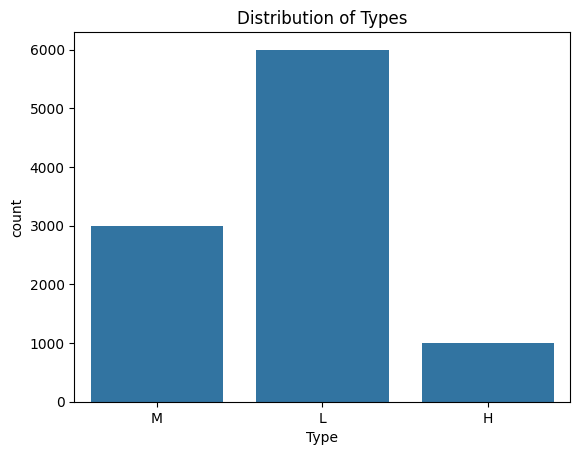

In [53]:
sns.countplot(x='Type', data=df)
plt.title('Distribution of Types') 
plt.show()

**Observations:**

- low quality varient makes up majority of the dataset with 60% of the data, followed by medium quality varient with 30% and high quality varient with 10%.

In [54]:
df['Type'].value_counts()/len(df)*100

Type
L    60.00
M    29.97
H    10.03
Name: count, dtype: float64

### Question 3

**What is the range of values for the continuous variables 'air temperature', 'process temperature', 'rotational speed', 'torque', and 'tool wear'? Are there any outliers in the dataset?**

In [56]:
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig = make_subplots(rows=5, cols=1, subplot_titles=num_cols, vertical_spacing=0.04)


for i, col in enumerate(num_cols):
    box_plot = go.Box(x=df[col], name=col)
    fig.add_trace(box_plot, row=i+1, col=1)

fig.update_layout(
    title="Distribution of Numerical Features",
    height=1200,
    width=900,
    title_text="Box plots"
)

fig.show()

**Observations:**

- Torque and rotational speed have outliers in the dataset

In [57]:
outlier_cols = ['Torque [Nm]', 'Rotational speed [rpm]']

fig2 = make_subplots(rows=1, cols=2, subplot_titles=outlier_cols, vertical_spacing=0.03)

for i, col in enumerate(outlier_cols):
    box_plot = go.Histogram(x=df[col], name=col)
    fig2.add_trace(box_plot, row=1, col=i+1)

# fig2 = px.histogram(df, x=outlier_cols, nbins=50, marginal='box', opacity=0.7)

fig2.update_layout(
    title='Distribution of Torque and Rotational speed',
    yaxis_title='Frequency',
    title_text="Histograms",
    width=900
)
fig2.show()

### Question 4

**Is there any correlation between the continuous variables and the 'Target' label? For example, does the tool wear increase the likelihood of machine failure?**

In [58]:
corr_matrix = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target']].corr()

fig = px.imshow(corr_matrix, zmin=-1, zmax=1, text_auto=True)

fig.update_layout(
    title='Correlation Matrix',
    height=600,
    width=800
)

fig.show()

**Null Hypothesis:** There is no signifcant relationship between the different columns and Machine Failure.

**Alternate Hypothesis:** There is a significant relationship between the tool wear and the machine failure label.

In [59]:
test_cols = ['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']
values = []

for col in test_cols:
    failed = df[df['Target'] == 1][col]
    non_failed = df[df['Target'] == 0][col]

    t, p = ttest_ind(failed, non_failed)
    values.append([t, p])

values = pd.DataFrame(values, columns=['test-statistic', 'p-value'], index=test_cols)
alpha = 0.05
values['Hypothesis'] = values['p-value'].apply(lambda p: 'Reject null hypothesis' if p < alpha else 'Accept null hypothesis')
values

,test-statistic,p-value,Hypothesis
Air temperature [K],8.283018,1.354800e-16,Reject null hypothesis
Process temperature [K],3.596562,3.240058e-04,Reject null hypothesis
Rotational speed [rpm],-4.422634,9.853543e-06,Reject null hypothesis
Torque [Nm],19.490196,4.573805e-83,Reject null hypothesis
Tool wear [min],10.602881,3.976076e-26,Reject null hypothesis


### Question 5

**Are there any interactions or non-linear relationships between the variables that may be relevant for predictive maintenance? For example, does the torque increase exponentially with the rotational speed?**

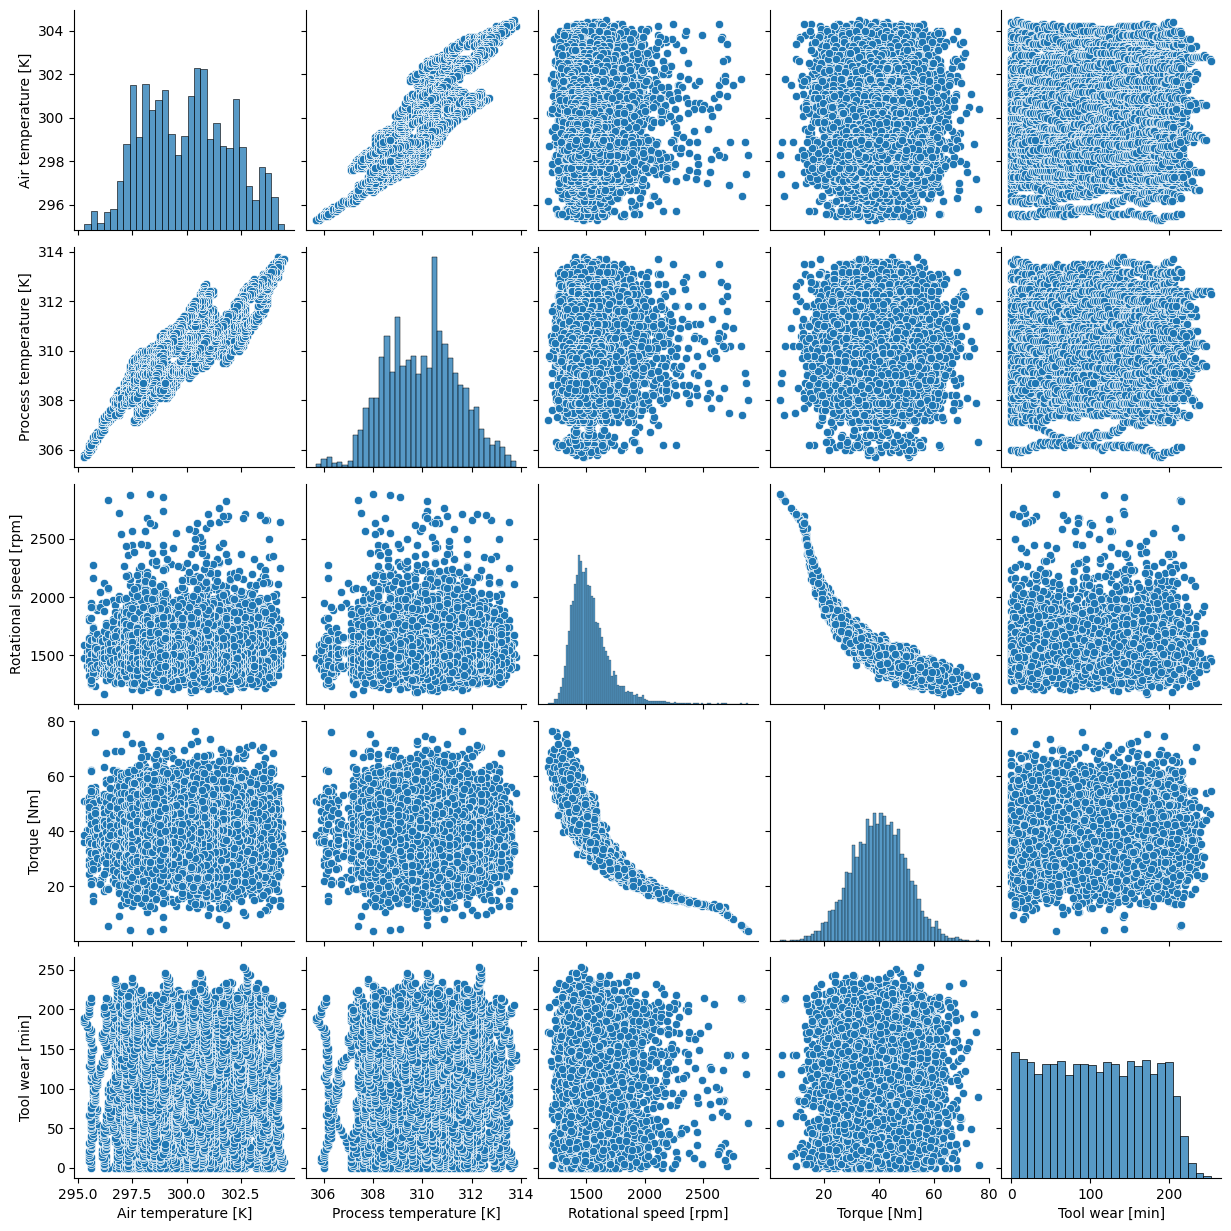

In [60]:
num_cols = df[['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']]
sns.pairplot(num_cols)

**Observations:**

- Among all possible combinations of continuous variables, Rotational Speed vs Torque have a negative correlation and Process Temperature vs Air temperature have a positive correlation.

# Data Preprocessing

In [61]:
df.drop(['UDI','Product ID'],axis=1, inplace=True)
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,H,299.0,308.7,1408,48.5,25,0,No Failure


In [62]:
df['Air temperature [c]'] = df['Air temperature [K]'] - 273.15
df['Process temperature [c]'] = df['Process temperature [K]'] - 273.15
df.drop(['Air temperature [K]', 'Process temperature [K]'], axis=1, inplace=True)
df.head()

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [c],Process temperature [c]
0,M,1551,42.8,0,0,No Failure,24.95,35.45
1,L,1408,46.3,3,0,No Failure,25.05,35.55
2,L,1498,49.4,5,0,No Failure,24.95,35.35
3,L,1433,39.5,7,0,No Failure,25.05,35.45
4,L,1408,40.0,9,0,No Failure,25.05,35.55


In [63]:
encoder = OrdinalEncoder(categories=[['L','M','H']])

df['Type'] = encoder.fit_transform(df[['Type']])
df

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [c],Process temperature [c]
0,1.0,1551,42.8,0,0,No Failure,24.95,35.45
1,0.0,1408,46.3,3,0,No Failure,25.05,35.55
2,0.0,1498,49.4,5,0,No Failure,24.95,35.35
3,0.0,1433,39.5,7,0,No Failure,25.05,35.45
4,0.0,1408,40.0,9,0,No Failure,25.05,35.55
...,...,...,...,...,...,...,...,...
9995,1.0,1604,29.5,14,0,No Failure,25.65,35.25
9996,2.0,1632,31.8,17,0,No Failure,25.75,35.25
9997,1.0,1645,33.4,22,0,No Failure,25.85,35.45
9998,2.0,1408,48.5,25,0,No Failure,25.85,35.55


In [64]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [65]:
encoder = LabelEncoder()

df['Failure Type'] = encoder.fit_transform(df['Failure Type'])
df.head()

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Air temperature [c],Process temperature [c]
0,1.0,1551,42.8,0,0,1,24.95,35.45
1,0.0,1408,46.3,3,0,1,25.05,35.55
2,0.0,1498,49.4,5,0,1,24.95,35.35
3,0.0,1433,39.5,7,0,1,25.05,35.45
4,0.0,1408,40.0,9,0,1,25.05,35.55


In [66]:
df['Failure Type'].unique()

array([1, 3, 5, 2, 4, 0])

In [67]:
encoder.classes_

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

In [68]:
classes = [0, 1, 2, 3,4, 5]
encoder.inverse_transform(classes)

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

In [69]:
df['Failure Type'].value_counts()

Failure Type
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64

In [70]:
df.groupby('Target')['Failure Type'].value_counts()

Target  Failure Type
0       1               9643
        4                 18
1       0                112
        3                 95
        2                 78
        5                 45
        1                  9
Name: count, dtype: int64

In [71]:
df['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

# Data Splitting

In [72]:
scaler = MinMaxScaler()
scaler_cols = ['Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Air temperature [c]', 'Process temperature [c]']

X = df.drop(['Target','Failure Type'], axis = 1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[scaler_cols] = scaler.fit_transform(X_train[scaler_cols])
X_test[scaler_cols] = scaler.transform(X_test[scaler_cols])

smote =  SMOTEENN(sampling_strategy="minority")
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)




In [73]:
y_train_resample

0        0
1        0
2        0
3        0
4        0
        ..
14611    1
14612    1
14613    1
14614    1
14615    1
Name: Target, Length: 14616, dtype: int64

# Model Training

In [74]:
lr = LogisticRegression()
sv = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

models = [lr, sv, dt, rf]
scores = []

for model in models:
    model.fit(X_train_resample, y_train_resample)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    rec = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    scores.append([acc, prec, rec, f1])

In [75]:
scores_df = pd.DataFrame(columns=['Model'], data=['Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest'])
scores_df = pd.concat([scores_df, pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall', 'F1'])], axis=1 )
scores_df

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,80.20,11.845103,85.245902,20.800000
1,SVC,88.60,19.855596,90.163934,32.544379
2,Decision Tree,94.05,30.136986,72.131148,42.512077
3,Random Forest,95.05,36.428571,83.606557,50.746269
